         date  confirmed_cases
0  2022-02-22           189565
1  2022-02-23           198478
2  2022-02-24           207599
3  2022-02-25           217932
4  2022-02-26           292792


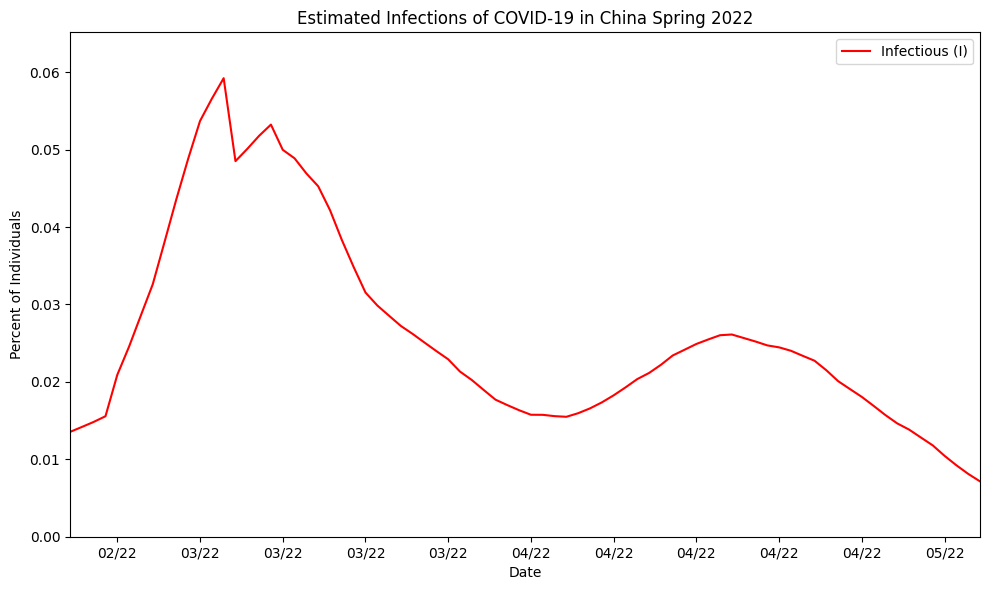

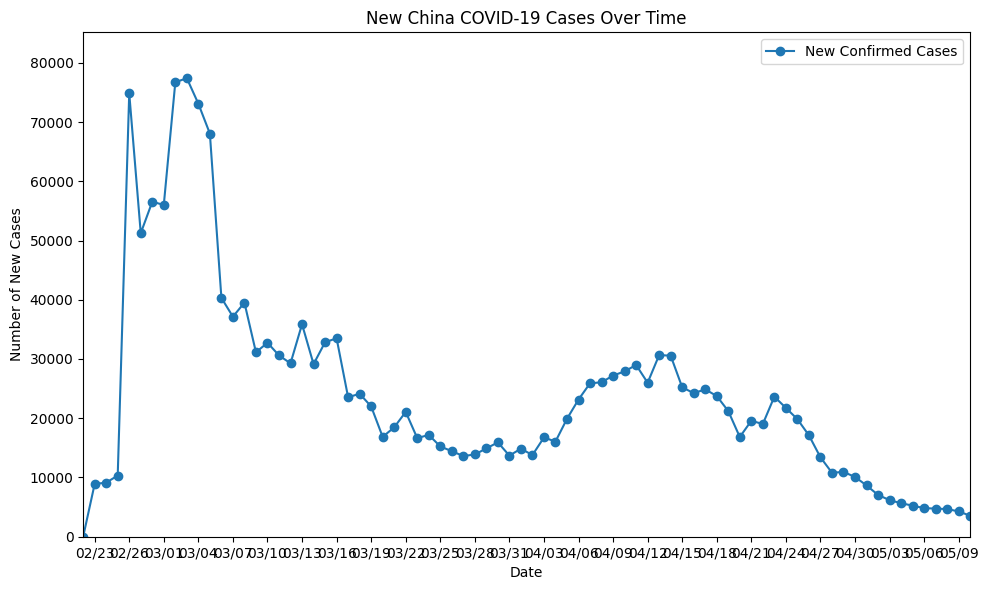

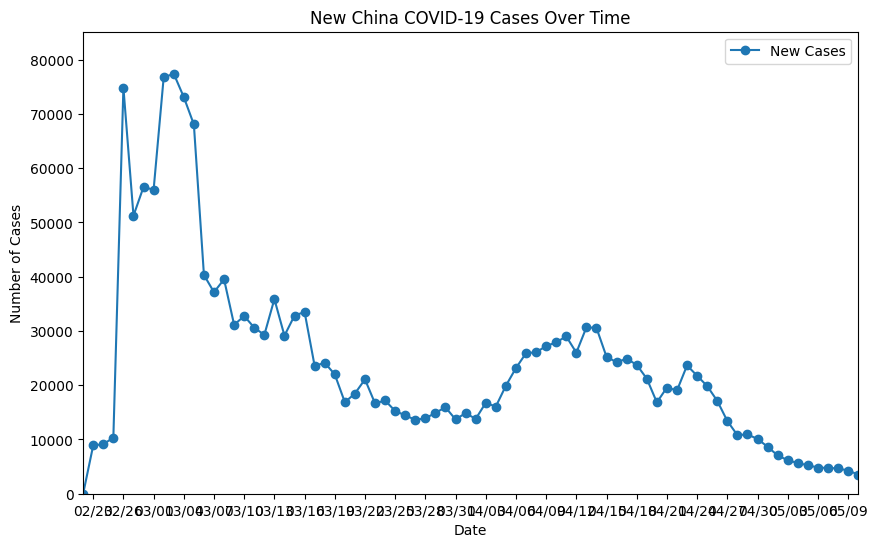

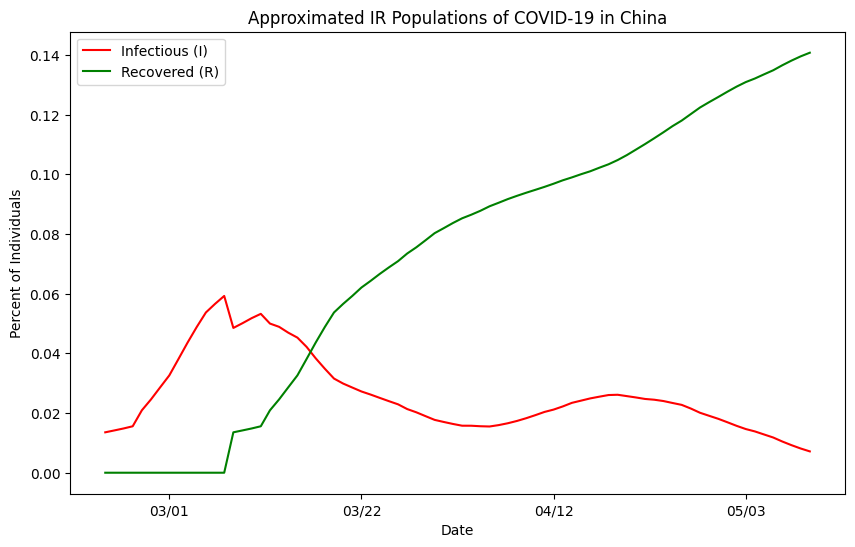

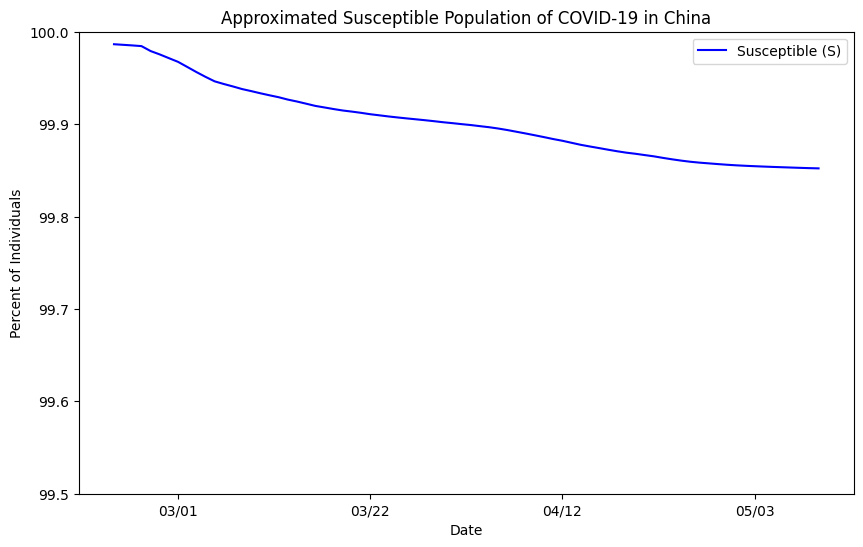

In [33]:
## LOAD YOUR DATASET HERE.
from main_functions import convert_cumulative_to_SIR
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1. Read in the csv file of cumulative cases.
data = pd.read_csv("./data/covid_china_data_spring_2022_cumulative.csv")
# Display the first few rows of the dataset
print(data.head())

# Ensure date column is in datetime format
data["date"] = pd.to_datetime(data["date"])

# preprocess:
# 2. Use the convert_cumulative_to_SIR function to convert cumulative cases to approximate S, I, R at any given time.
# new cases each day does not represent the number of currently infectious individuals I(t)
# Let's use the convert_cumulative_to_SIR function to approximate S(t), I(t), and R(t) from the data
population = 1.4e9 # China population approx as of 2022
data_sir = convert_cumulative_to_SIR(
    data,
    date_col="date",
    cumulative_col="confirmed_cases",
    population=population,
    infectious_period=14,
    new_case_col="new_cases",
    I_col="I_est",
    R_col="R_est",
    S_col="S_est",
)

# Ensure date column in data_sir is in datetime format
data_sir["date"] = pd.to_datetime(data_sir["date"])

# 3. Plot S, I, R over time.

plt.figure(figsize=(10, 6))

# convert I_est to percent of population to match the axis label
I_pct = data_sir["I_est"] / population * 100.0
plt.plot(data_sir["date"], I_pct, label="Infectious (I)", color="red")

plt.xlabel("Date")
plt.xlim(pd.Timestamp("2022-02-22"), pd.Timestamp("2022-05-10"))

# dynamic y-limits so the curve isn’t squashed or clipped
plt.ylim(0, I_pct.max() * 1.1)

# use a portable date format string and a reasonable locator
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%m/%y"))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))

plt.ylabel("Percent of Individuals")
plt.title("Estimated Infections of COVID-19 in China Spring 2022")
plt.legend()
plt.tight_layout()
plt.show()

# Let's look at new infections (incidence) over time: I(t)

# notice that we are taking the difference between days to get new cases
data["new_cases"] = data["confirmed_cases"].diff().fillna(0)

plt.figure(figsize=(10, 6))
plt.plot(data["date"], data["new_cases"], label="New Confirmed Cases", marker="o")
plt.xlabel("Date")

# dynamic y-limits so we see the full range of new cases
plt.ylim(0, data["new_cases"].max() * 1.1)

plt.xlim(pd.Timestamp("2022-02-22"), pd.Timestamp("2022-05-10"))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))

plt.ylabel("Number of New Cases")
plt.title("New China COVID-19 Cases Over Time")
plt.legend()
plt.tight_layout()
plt.show()

# here
plt.figure(figsize=(10, 6))
plt.plot(data["date"], data["new_cases"], label="New Cases", marker="o")
plt.xlabel("Date")
plt.ylim(0, data["new_cases"].max() * 1.1)
plt.xlim(pd.Timestamp("2022-02-22"), pd.Timestamp("2022-05-10"))

# Format ticks as M/Y (no leading zeros)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))

plt.ylabel("Number of Cases")
plt.title("New China COVID-19 Cases Over Time")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))

S_pct = data_sir["S_est"] / population * 100.0
I_pct = data_sir["I_est"] / population * 100.0
R_pct = data_sir["R_est"] / population * 100.0

# Plot only I and R so they are visible on the same scale
plt.plot(data_sir["date"], I_pct, label="Infectious (I)", color="red")
plt.plot(data_sir["date"], R_pct, label="Recovered (R)", color="green")

plt.xlabel("Date")
# plt.ylim(0, 8e9)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
plt.ylabel("Percent of Individuals")
plt.title("Approximated IR Populations of COVID-19 in China")
plt.legend()
plt.show()

# SEPARATELY PLOTTED: S, the susceptible population, is very close to 100% throughout the time period

plt.figure(figsize=(10, 6))
plt.plot(data_sir["date"], S_pct, label="Susceptible (S)", color="blue")
plt.xlabel("Date")
plt.ylim(99.5, 100)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
plt.ylabel("Percent of Individuals")
plt.title("Approximated Susceptible Population of COVID-19 in China")
plt.legend()
plt.show()

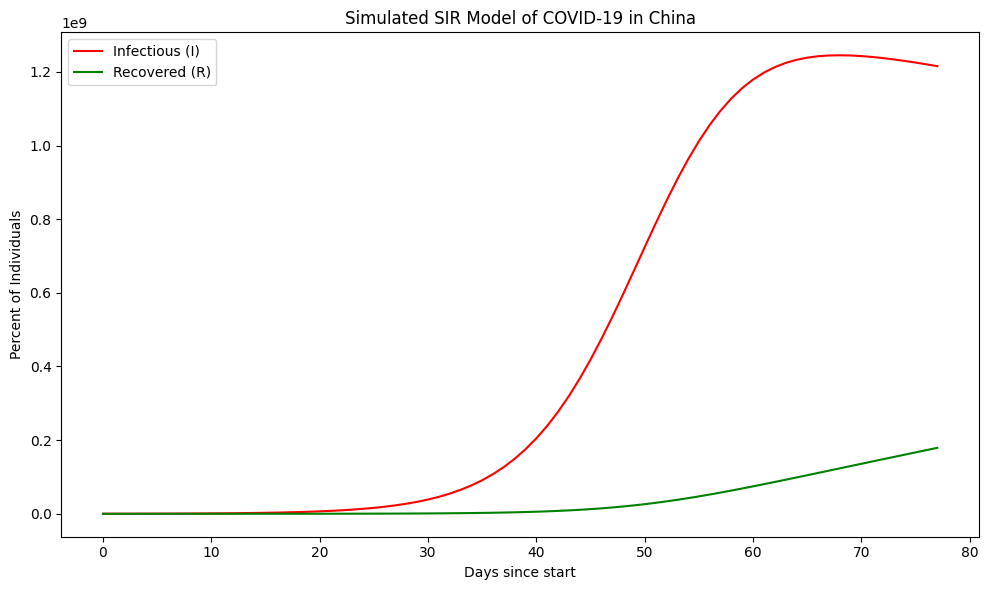

TypeError: Addition/subtraction of integers and integer-arrays with Timestamp is no longer supported.  Instead of adding/subtracting `n`, use `n * obj.freq`

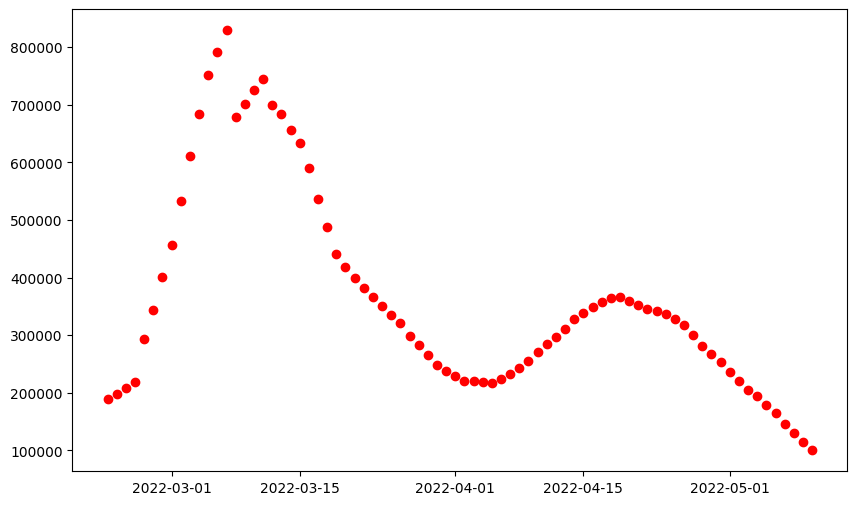

In [34]:
# euler's method to simulate SIR model
import numpy as np
from main_functions import euler_sir

def euler_sir_plot(beta, gamma, S0, I0, R0, population, plot=False):


    # Use realistic parameters for COVID-19
    beta = 0.2  # infection rate (per day)
    gamma = 0.005  # recovery rate (per day)

    I0 = data_sir["I_est"].iloc[0]  # initial infected
    S0 = population - I0  # initial susceptible
    R0 = 0  # initial recovered

    # model through entire period
    days = (data_sir["date"].max() - data_sir["date"].min()).days
    t = np.arange(days + 1)  # time array, 0 to days

    # TODO: replace
    # t = np.arange(1000)

    S, I, R = euler_sir(beta, gamma, S0, I0, R0, t, population)
    if not plot:
        return S, I, R

    # plot the results as percent of population
    plt.figure(figsize=(10, 6))
    plt.plot(t, I, label="Infectious (I)", color="red")
    # plt.plot(t, S, label="Susceptible (S)", color="blue")
    plt.plot(t, R, label="Recovered (R)", color="green")
    plt.xlabel("Days since start")
    plt.ylabel("Percent of Individuals")
    plt.title("Simulated SIR Model of COVID-19 in China")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # plot over I(t) estimated from data
    plt.figure(figsize=(10, 6))
    plt.plot(data_sir["date"], data_sir["I_est"], label="Estimated Infectious (I)", color="red", marker="o", linestyle="None")
    plt.plot(t + (data_sir["date"].min()), I, label="Simulated Infectious (I)", color="orange")
    plt.xlabel("Date")
    plt.ylabel("Percent of Individuals")
    plt.title("Estimated vs Simulated Infectious Population of COVID-19 in China")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return S, I, R

euler_sir_plot(beta=0.2, gamma=0.005, S0=population - 1, I0=1, R0=0, population=population, plot=True)
pass

In [31]:
# scipy optimize
import scipy.optimize as opt

# error of the SIR model compared to estimated I(t)
def sir_model_error(params, data_sir, population):
    
    beta, gamma = params
    S0 = population - 1
    I0 = data_sir["I_est"].iloc[0]
    R0 = 0

    days = (data_sir["date"].max() - data_sir["date"].min()).days
    t = np.arange(days + 1)

    S, I, R = euler_sir(beta, gamma, S0, I0, R0, t, population)

    # Interpolate model I values to match data_sir dates
    model_I_interp = np.interp(
        (data_sir["date"] - data_sir["date"].min()).dt.days,
        t,
        I
    )

    # Calculate error as sum of squared differences
    error = np.sum((data_sir["I_est"] - model_I_interp) ** 2)
    return error

# Initial guess for beta and gamma
initial_params = [0.2, 0.005]
# Optimize parameters to minimize error
pop_test = 1.4e6
optimized_params = opt.minimize(sir_model_error, initial_params, args=(data_sir, pop_test), bounds=[(0.00001, 10.0), (0.00001, 2.0)])
beta_opt, gamma_opt = optimized_params.x
print(f"Optimized beta: {beta_opt}, Optimized gamma: {gamma_opt}")

Optimized beta: 0.21877759543509798, Optimized gamma: 0.06029811445202298


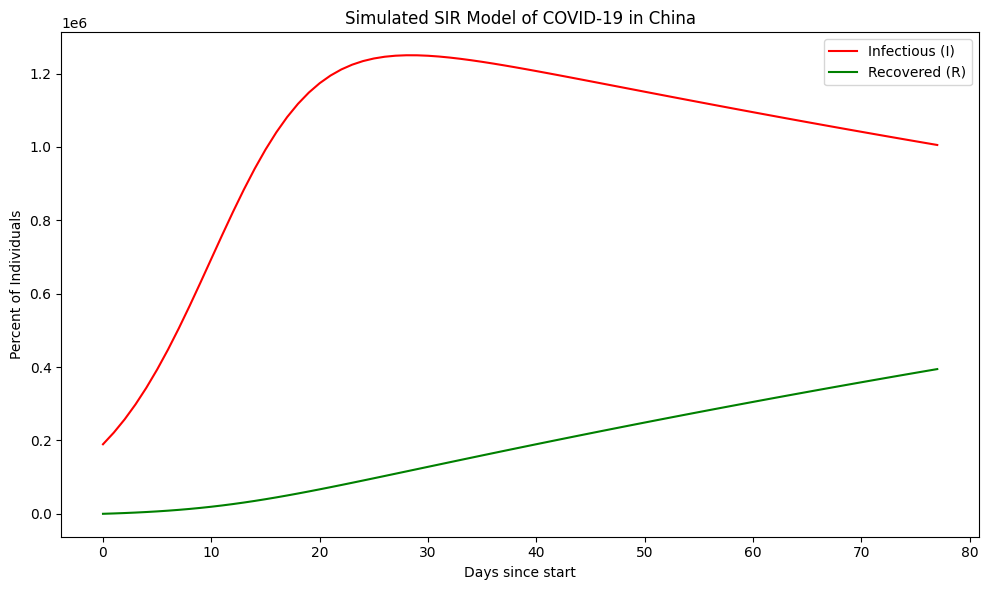

In [32]:
euler_sir_plot(
    beta=beta_opt,
    gamma=gamma_opt,
    S0=pop_test - 1,
    I0=1,
    R0=0,
    population=pop_test,
    plot=True,
)
pass